![example](images/tz_pump_pic.jpeg)

# Tanzania Machine Learning Water Pump Classification
## Data Exploration Notebook

**Author:** Dylan Dey

This project it available on github here: (insert link here)

The Author can reached by email: ddey2985@gmail.com 

## Overview

The website ['DrivenData'](https://www.drivendata.org/about/) finds partners to collaborate with in order to aggregate data to make available in an open competition of Data Scientists from around the globe to come together to solve large social issues. For this project, DrivenData partnered with Taarifa and the Tanzanian Ministry of Water in order to predict the functionality of water pumps in the country of Tanzania. Machine learning classifiers from the [‘scikit-learn ‘](https://scikit-learn.org/stable/)  library were used to create a model for predictive maintenance of the water pumps. 

## Business Problem


### Tanzania Water Scarcity
Several water points are established in Tanzania which currently supply the population with water, although this system is quite inefficient. Poor infrastructure and spotty maintenance plague the system with broken taps, broken pipes, and damaged supply sources. In addition,  water pumps and plumbing make attractive targets for thieves. These factors and others block access to clean water from the established system. 

The most common form of maintenance for these points is to repair them once they are no longer functional. This is not very efficient and is somewhat expensive, but it is magnitudes cheaper than establishing a new water point through drilling and installing of large equipment. 

A better approach would be to prevent repairs from becoming necessary in the first place. 
Predictive maintenance constantly monitors the status of pumps in order to more efficiently maintain them. This is the goal of this project. Timely verification of the status of water pumps in the region can prevent further compounding of issues and can reduce maintenance costs significantly. Most importantly, it can bring fresh water to those who need it in a more efficient manner than before it was implemented.

For the past two decades, the Ministry of Water has been implementing sector reforms that aim at improving resource management and improving water supply in both rural and urban environments. An attempt to determine if predictive maintenance could help the Ministry of Water in the overall success of their mission statement.

Because the first goal is to predict if an unknown water pump is either functional or nonfunctional before ever sending anyone to physically check the pump I decided to simplify things for this project and only predict two labels instead of the three described by DrivenData in their competition. Future work  could prove valuable to treat the issues as a tertiary classification problem,  with focus on creating a more sophisticated model with proper class imbalance techniques. Focusing for now on creating a strong predictive model for a binary classification problem can be very beneficial for the immediate needs of the Ministry of Water.

A team will need different equipment, training, and other resources in order to do simple maintenance on a functional pump versus fully repairing a non-functional pump. It is critical to improve the efficiency of pump maintenance and repair to ensure more people can get what they need to survive as quickly as possible. 

Without any model to make predictions, the Ministry of Water would have to physically check all of the pumps. The teams sent could  bring just what they would need to maintain clean pumps, and only have what they need for a little over half of the pumps. Then they could record which pumps were maintained and which pumps still need to be repaired, go back to base, gather the proper supplies, and deploy again with the proper resources. 

The ‘date recorded’ column in the dataset available from the DrivenData competition reveals that in 2011 nearly 28k? Water pumps were physically checked for their status. This seems to be the current capacity for just the exploratory part of maintenance before ever sending the proper equipment or supplies to fix what needs fixed. We could imagine how resource intensive this could be through a little bit of speculation. If one team could check 3 pumps a day, worked five days a week with no holidays, and never took any additional time off, it would still take around 40 teams even under these unrealistic, intense conditions. This doesn't even consider the few months a year that Tanzania has heavy rains that could prove to slow progress even further. These 40 teams would need the proper equipment to navigate long distances. Tanzania has some of the most diverse geography in the world, with from some of the world’s tallest mountain ranges and volcanoes, dense jungle, arid grassland with no shade from the intensity of the African sun, treacherous valleys, and seasonal flooding as just some features of Tanzania geography that can impede this first round of physical exploration before the second round in which resources can finally be directed to where they need to be. This burden can significantly lower whatever money and resources would even be left to buy and send the equipment that is needed after funding all of this exploration.

Thus, being able to reliably predict the status of a pump without physically checking the water pump could be extremely important. Reducing the amount of resources necessary for this crucial step can free up resources to return functionality to important water points to the communities that desperately need them, increasing the amount of people with access to fresh water. Furthermore, these communities will get access to fresh water on a much shorter timeline. 

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling
from collections import Counter
from sklearn.preprocessing import OneHotEncoder

sns.set_theme(style="darkgrid")

## Data Understanding

### Target: status_group

There is a clear class imbalance when looking at the distrubtion of the three target labels. There are a lot fewer pumps that are functional but need repair than either the function or non functional pumps. This could create a bias in my models towards the heavier weighted samples unless I attempt to balance the data. For my project, I decided to simplify things and create a binary classifcation model that identifies pumps as either being functional or non-functional. All functional-needs-repair pumps will be binned with non-functional pumps. Future work will focus on more sophisticated methods to handle the class imbalance and build a model to solve a tertiary problem instead.

## Data Understanding



In [2]:
train_labels = pd.read_csv('data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
display(train_labels.head())
train_labels.status_group.value_counts(normalize=True)

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

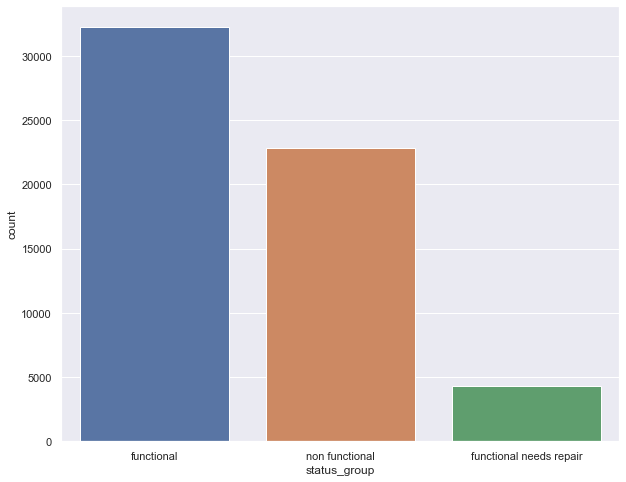

In [3]:
fig = plt.figure(figsize=(10,8))
sns.countplot(x='status_group', data=train_labels)
plt.show();

In [4]:
train_features = pd.read_csv('data/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
#merge training features and training labels in order
#to explore the data
df = train_features.merge(train_labels, on='id').copy()

## Geodata Exploration

### River Distance using QGIS

In [6]:
#create a subset of data that just contains
#coordinates of the pumps
#in order to analyze using free open source
#QGIS software and open GIS data
latlong = df[['latitude', 'longitude', 'status_group']]
latlong.to_csv('data/latlong2.csv')

The map below was created using QGIS software. Green doots represent fully functional pumps. Yellow dots refer to pumps that are functional but in need of repair. The red dots are the pumps that are non-functional. A quick glance will reveal that there are some clusters that represent different distrubtions of functional to non functional pumps. However, it doesn't look like latitude or longitude alone would be very predictive variables to consider. Will drop latitude and longitude for modeling and keep other more broad geological predictors. 

![water_pump_map](images/map_image.png)


click below for a pdf version of map with zoom functionality.

[water_pump_pdf](images/map_image.png.pdf)

Knowing what pumps are functional/nonfunctional and being sure about it can prove essential for our predictive maitenance model. In this way, we can save resources by being sure which communities already have what they need vs communities that are more desperate for assistance and resources. There is a strong class imbalance in the tertiary model. In the future I would like to use more sophisticated methods to try to deal with the class imbalance and make predictions on all 3 labels. It could help to save even more money and resources to be able to accurately distinguish between functional needs repair and non functional. However, for now, I think building a reasonably accurate binary model is an excellent starting place for predictive maintenance. 

In [7]:
need_repair_index = df['status_group'] == 'functional needs repair'
df_binary = df.copy()
df_binary.loc[need_repair_index, 'status_group'] = 'non functional'

In [8]:
df_binary['status_group'].value_counts()

functional        32259
non functional    27141
Name: status_group, dtype: int64

Below is an unpdated map for a binary classifcation model.


![water_pump_map](images/binary_map.png)



click below for a pdf version of map with zoom functionality.

[water_pump_pdf](images/binary_map2.pdf)

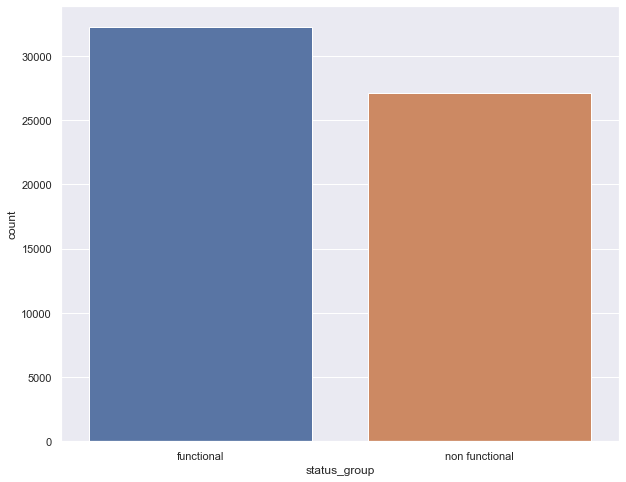

In [9]:
fig = plt.figure(figsize=(10,8))
sns.countplot(x='status_group', data=df_binary)
plt.show();

In [10]:
river_df = pd.read_csv('data/river_dist2.csv')
river_df.head()

,field_1,latitude,longitude,HubName,HubDist
0,0,-9.856322,34.938093,River/Stream,8.025861
1,1,-2.147466,34.698766,River/Stream,7.538778
2,2,-3.821329,37.460664,River/Stream,2.523575
3,3,-11.155298,38.486161,River/Stream,8.307942
4,4,-1.825359,31.130847,River/Stream,4.524439


In [11]:
#because some of the distance vectors were created with false coordinates
#I decided to fill in the incorrect distance values
#with the median distance for distance to nearest river
#there are about 1800 rows with incorrect lat/long coordinates
#these 1800 rows show lat/long values of zero which 
#are obvious outliers when plotted on a map

index_riv = river_df[river_df['HubDist'] >66].index
river_median = river_df['HubDist'].median()
river_df.loc[index_riv, 'HubDist'] = river_median
river_df['HubDist'].describe()

count    59400.000000
mean         8.520694
std          6.833602
min          0.035102
25%          4.237760
50%          7.115599
75%         10.669175
max         65.057665
Name: HubDist, dtype: float64

In [12]:
#create a booleon feature describing whether
#a water pump is within 8 km of a river

river_s = river_df['HubDist'].copy()
river_s.rename('near_river', inplace=True) 
near_river = river_s[river_s < 8].apply(lambda x: 1 if not pd.isnull(x) else np.nan)
df = df.join(near_river)
df.near_river.fillna(0, inplace=True)
df.near_river.value_counts(normalize=True)

1.0    0.597323
0.0    0.402677
Name: near_river, dtype: float64

In [13]:
display(df[df['near_river'] == 1]['status_group'].value_counts(normalize=True))
df[df['near_river'] == 0]['status_group'].value_counts(normalize=True)

functional                 0.555311
non functional             0.369663
functional needs repair    0.075026
Name: status_group, dtype: float64

functional                 0.524938
non functional             0.405870
functional needs repair    0.069192
Name: status_group, dtype: float64

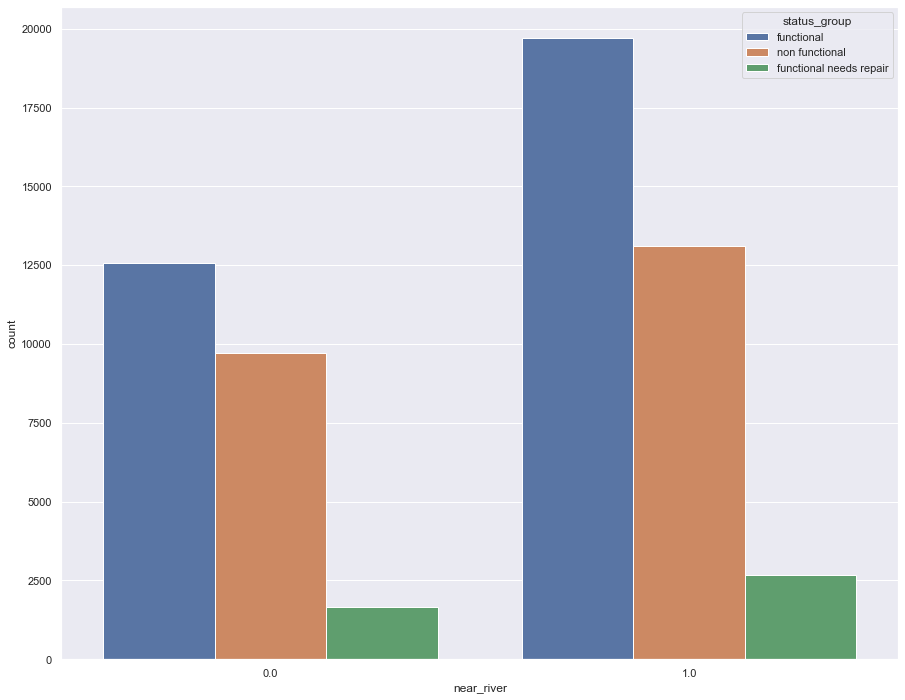

In [14]:
fig = plt.figure(figsize=(15,12))
sns.countplot(x='near_river', hue='status_group', data=df)
plt.show();

In [15]:
#profile = pandas_profiling.ProfileReport(df.copy())
#profile.to_file("output.html")

#### Adding Population data by ward


The column describing population is heavily skewed towards a value of zero, and it would seem very unlikely for so many wells to have a population of zero. Nearly 50% of the data is skewed towards a value of either zero or one. It is hard to trust the validaty of this column. I decided to drop this column and bring in population information by ward collected by government census in 2012. This data has its own issues but I believe it to be a more complete dataset and give a better idea about the number of people who could benefit from the presence of a functional well in their area. Ward is a pretty high level division of geological boundaries for Tanzania. May have to revisit this population data at a later date. 

In [16]:
df_pop = pd.read_excel('data/tza-pop-popn-nbs-baselinedata-xlsx-1.xlsx')
display(df_pop.head())
df_pop['Ward_Name'].isna().sum()

,Reg_Code,Reg_Name,Dis_Code,Dis_Name,Ward_Code,Ward_Name,Division,PCode,total_both,total_male,...,rural_both,rural_male,urban_both,urban_male,urban_fema,rural_fema,area_km2,status,ward_type,Pop_Den
0,1,Dodoma,1,Kondoa,11,Bumbuta,NaN,101011,8602,4433,...,8602,4433,0,0,0,4169,189.981680,1,Rural,45
1,1,Dodoma,1,Kondoa,21,Pahi,NaN,101021,13944,7082,...,13944,7082,0,0,0,6862,109.924611,1,Rural,127
2,1,Dodoma,1,Kondoa,41,Haubi,NaN,101041,13757,7027,...,13757,7027,0,0,0,6730,150.395757,1,Rural,91
3,1,Dodoma,1,Kondoa,51,Kalamba,NaN,101051,13988,7023,...,13988,7023,0,0,0,6965,286.931082,1,Rural,49
4,1,Dodoma,1,Kondoa,61,Kwadelo,NaN,101061,11593,5801,...,11593,5801,0,0,0,5792,313.301277,1,Rural,37


0

In [17]:
#create a dictionary of values with format {Ward : Total Population}

pop_index = df_pop.groupby('Ward_Name')['total_both'].sum().index
pop_values = df_pop.groupby('Ward_Name')['total_both'].sum().values
pop_dict = dict(zip(pop_index, pop_values))

#create pandas Dataframe for merging
pop_dataframe = pd.DataFrame.from_dict(pop_dict, orient='index')
#rename column for clarity
pop_dataframe.rename(columns={0: 'ward_pop'}, inplace=True)

In [18]:
#merge dataframes
df_pop_merge = df.merge(pop_dataframe,
                              how='left',
                              left_on='ward',
                              right_index=True)   

df_pop_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [19]:
#replace null values of ward population with
#median ward population

ward_pop_median = df_pop_merge['ward_pop'].median()
df_pop_merge.fillna(value=ward_pop_median, inplace=True)
df_pop_merge['ward_pop'].isna().sum()

0

In [20]:
ward_pop_s = df_pop_merge['ward_pop'].copy()
df = df.join(ward_pop_s)
df.drop(columns=['population'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [21]:
fig_df = df.copy()
to_drop_index = fig_df[fig_df['longitude'] == 0].index
fig_df = fig_df.drop(to_drop_index)

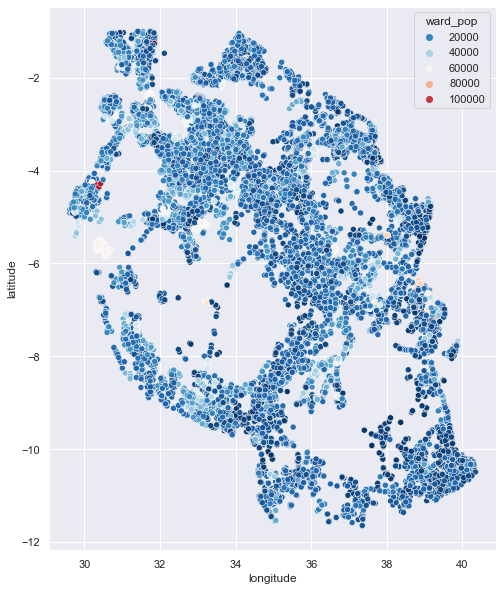

In [22]:
#wquick visualization of the density of population around pumps
#derived from ward population government census data
pop_fig = plt.figure(figsize=(8,10))
sns.scatterplot(x='longitude',
                y='latitude',  
                hue='ward_pop', 
                data=fig_df,
                palette="RdBu_r",
               )
plt.show();

##### Binary Classification Model Binning

In [23]:
df_binary = df.copy()
df_binary.loc[need_repair_index, 'status_group'] = 'non functional'

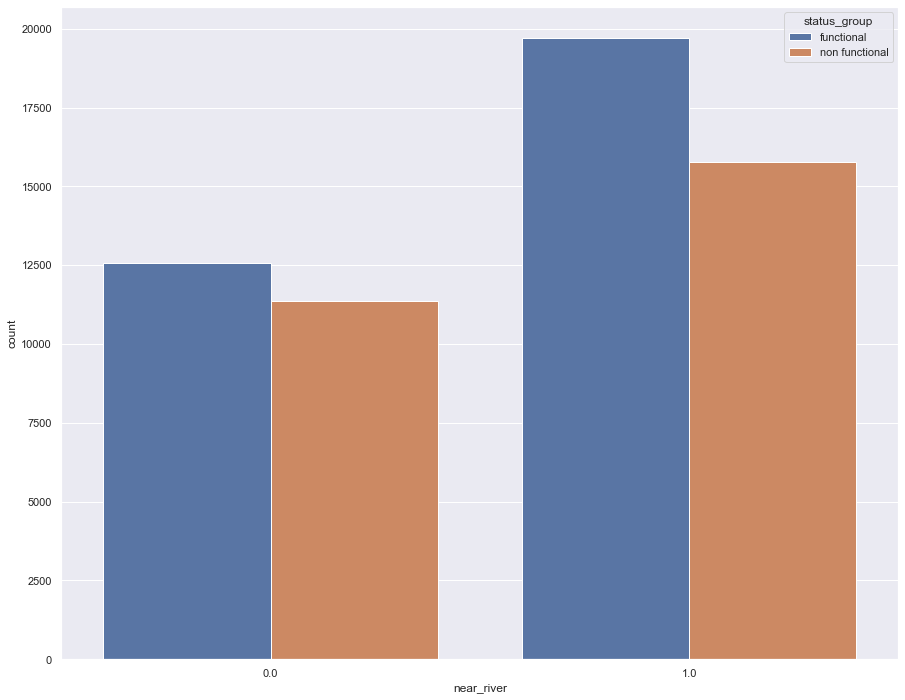

In [24]:
fig = plt.figure(figsize=(15,12))
sns.countplot(x='near_river', hue='status_group', data=df_binary)
plt.show();

At this point, I have my dataframe that I will treat as my raw data.

## Data Cleaning

### Dropping Redundant and Uninformative Columns Overview


Below are the columns that I decided to drop initially and the reasoning behind dropping the column. This step will help overall model speeds and should reduce the chance of overfitting by cutting down on multicolinearity. 

**id:** uninformitave  
**recorded_by:** constant, unimportant for model  
**num_private:** nearly 99% zeroes. Uninformative for model.  
**waterpoint_type_group:** redundant. waterpoint_type covers same information.  
**source:** Explains same information as source_type but with more variables. Keeping source_type.  
**source_class:** Broadly explains same information as source and source_type. Keeping source_type.  
**Source_type:** This was NOT dropped. Kept it as a balance between the other two features of similar information.  
**extraction_type:**  explains similar information as extration_type_group and extraction_type_class. Dropped.   
**extraction_type_group:** explains similar information as extration_type and extraction_type_class. Dropped.   
**extraction_type_class:** broadly explains similar information as extraction_type and extraction_type_group. Kept.  
**payment:** redundant information. Keep this and drop 'payment type'    
**payment_type:** Same information as payment. Drop.   
**management:** keep this and drop 'management_type'.       
**management_group:** drop. Information contained within management column.     
**scheme_name:** drop. Missing almost half of values. Large cardinality (nearly 2700 categories).    
**scheme_manager:** drop. Contains similar information to management column.        
**water_quality:** Keep this and drop 'quality group.'
**water_quantity:** Keep this and drop water_quantity. They contain identical information.
**date_recorded:** administrative. Not predictive. 
**latitude**: No clear relationship between coordinate and pump status after viewing map. There is some obvious clustering though. Hope to get enough information from the other geological categorical features. Basin is likely to always show up in feature data as it is most general. Latitude and longitude for the pumps may even be imputed from mean or median values based on ward or some other common geological boundaries. Dropped.
**longitude**: See above comments on latitude. Dropped.

In [25]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'near_river', 'ward_pop'],
      dtype='object')

In [26]:
#view dataframe in different orientation
#to check for redundant information
df.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
id,69572,8776,34310,67743,19728,9944,19816,54551,53934,46144
amount_tsh,6000,0,25,0,0,20,0,0,0,0
date_recorded,2011-03-14,2013-03-06,2013-02-25,2013-01-28,2011-07-13,2011-03-13,2012-10-01,2012-10-09,2012-11-03,2011-08-03
funder,Roman,Grumeti,Lottery Club,Unicef,Action In A,Mkinga Distric Coun,Dwsp,Rwssp,Wateraid,Isingiro Ho
gps_height,1390,1399,686,263,0,0,0,0,0,0
installer,Roman,GRUMETI,World vision,UNICEF,Artisan,DWE,DWSP,DWE,Water Aid,Artisan
longitude,34.9381,34.6988,37.4607,38.4862,31.1308,39.1728,33.3624,32.6206,32.7111,30.627
latitude,-9.85632,-2.14747,-3.82133,-11.1553,-1.82536,-4.76559,-3.76636,-4.2262,-5.14671,-1.25705
wpt_name,none,Zahanati,Kwa Mahundi,Zahanati Ya Nanyumbu,Shuleni,Tajiri,Kwa Ngomho,Tushirikiane,Kwa Ramadhan Musa,Kwapeto
num_private,0,0,0,0,0,0,0,0,0,0


#### Water_quality vs Quality_group

Both of these columns contain essentially the same information, subgrouped differently. I decided to keep 'water_quality' and drop 'quality_group' in order to avoid overfitting issues and speed up the iterative modeling process. 

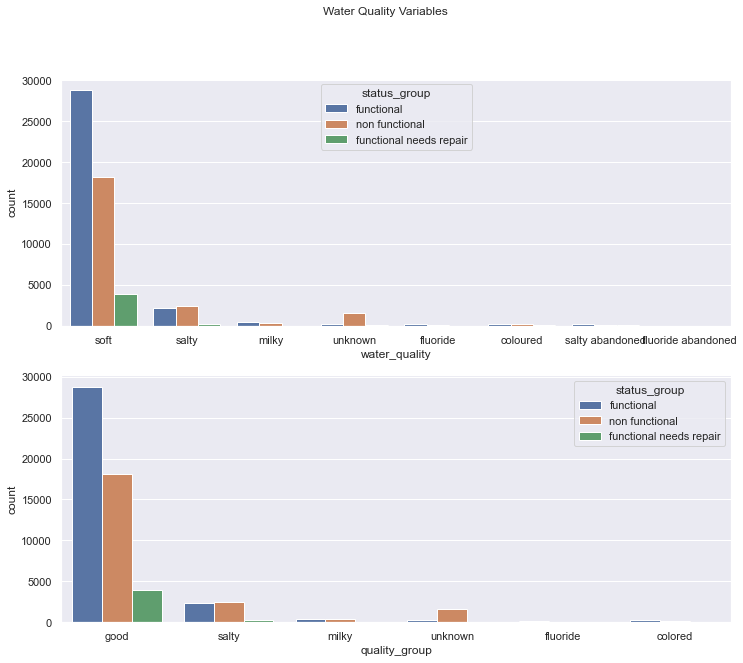

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10))
fig.suptitle('Water Quality Variables')
sns.countplot(x='water_quality', hue='status_group', data=df, ax=ax1)
sns.countplot(x='quality_group', hue='status_group', data=df, ax=ax2)
plt.show();

In [28]:
display(df.groupby('quality_group')['status_group'].value_counts(normalize=True))
df.groupby('water_quality')['status_group'].value_counts(normalize=True)

quality_group  status_group           
colored        functional                 0.502041
               non functional             0.387755
               functional needs repair    0.110204
fluoride       functional                 0.723502
               non functional             0.216590
               functional needs repair    0.059908
good           functional                 0.565941
               non functional             0.357236
               functional needs repair    0.076823
milky          functional                 0.544776
               non functional             0.437811
               functional needs repair    0.017413
salty          non functional             0.482002
               functional                 0.460828
               functional needs repair    0.057170
unknown        non functional             0.840618
               functional                 0.140725
               functional needs repair    0.018657
Name: status_group, dtype: float64

water_quality       status_group           
coloured            functional                 0.502041
                    non functional             0.387755
                    functional needs repair    0.110204
fluoride            functional                 0.755000
                    non functional             0.180000
                    functional needs repair    0.065000
fluoride abandoned  non functional             0.647059
                    functional                 0.352941
milky               functional                 0.544776
                    non functional             0.437811
                    functional needs repair    0.017413
salty               non functional             0.496499
                    functional                 0.457166
                    functional needs repair    0.046334
salty abandoned     functional                 0.513274
                    non functional             0.274336
                    functional needs repair    0.212389
soft

In [29]:
print('---------------------------------------------------')
display(df_binary.groupby('quality_group')['status_group'].value_counts(normalize=True))
df_binary.groupby('water_quality')['status_group'].value_counts(normalize=True)

---------------------------------------------------


quality_group  status_group  
colored        functional        0.502041
               non functional    0.497959
fluoride       functional        0.723502
               non functional    0.276498
good           functional        0.565941
               non functional    0.434059
milky          functional        0.544776
               non functional    0.455224
salty          non functional    0.539172
               functional        0.460828
unknown        non functional    0.859275
               functional        0.140725
Name: status_group, dtype: float64

water_quality       status_group  
coloured            functional        0.502041
                    non functional    0.497959
fluoride            functional        0.755000
                    non functional    0.245000
fluoride abandoned  non functional    0.647059
                    functional        0.352941
milky               functional        0.544776
                    non functional    0.455224
salty               non functional    0.542834
                    functional        0.457166
salty abandoned     functional        0.513274
                    non functional    0.486726
soft                functional        0.565941
                    non functional    0.434059
unknown             non functional    0.859275
                    functional        0.140725
Name: status_group, dtype: float64

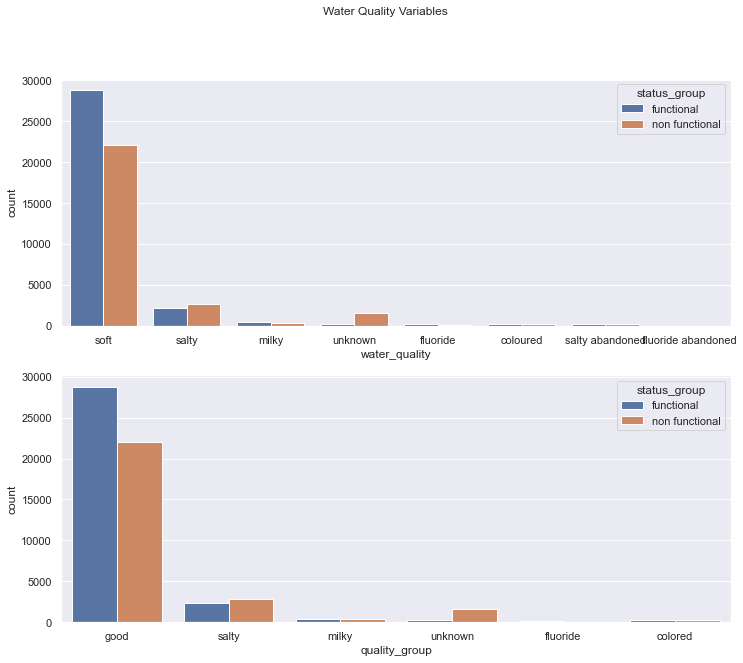

In [30]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10))
fig.suptitle('Water Quality Variables')
sns.countplot(x='water_quality', hue='status_group', data=df_binary, ax=ax1)
sns.countplot(x='quality_group', hue='status_group', data=df_binary, ax=ax2)
plt.show();

#### quantity and quantity_group
These columns are identical. Drop quantity group.

Quantity describes the amount of water avaiable. Dry pumps are non-functional, as expected. It is crucial that each pump has a sufficient water supply. 

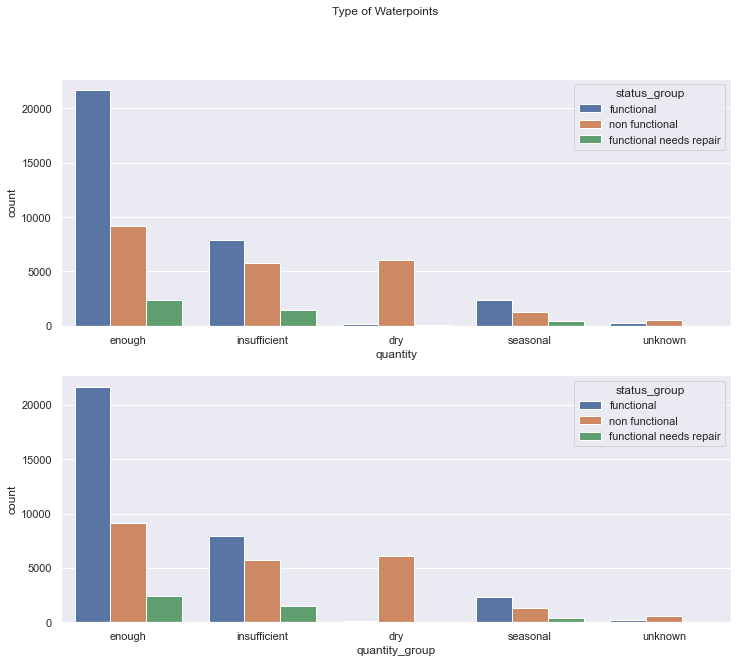

In [31]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10))
fig.suptitle('Type of Waterpoints')
sns.countplot(x='quantity', hue='status_group', data=df, ax=ax1)
sns.countplot(x='quantity_group', hue='status_group', data=df, ax=ax2)
plt.show();

Above: tertiary


Below: Binary

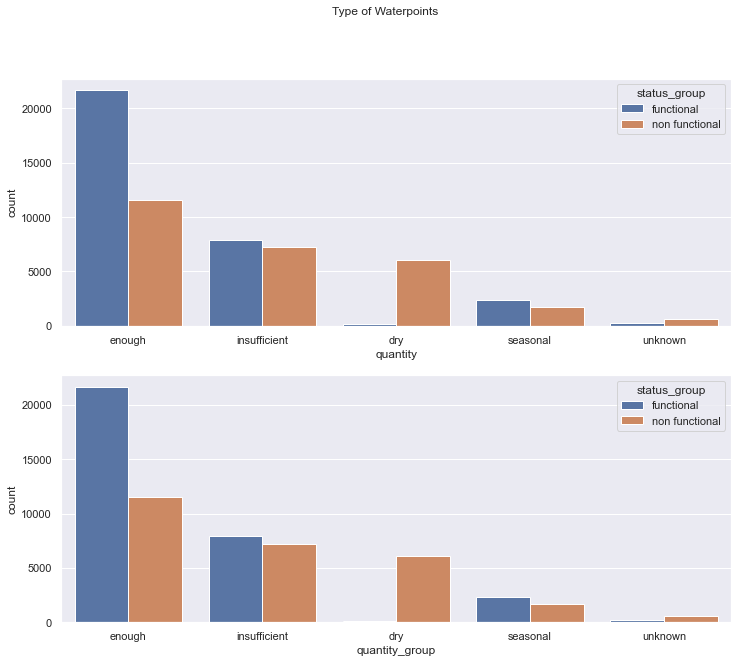

In [32]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10))
fig.suptitle('Type of Waterpoints')
sns.countplot(x='quantity', hue='status_group', data=df_binary, ax=ax1)
sns.countplot(x='quantity_group', hue='status_group', data=df_binary, ax=ax2)
plt.show();

#### waterpoint_type and waterpoint_type_group
Similar to what we saw above with water quality, both of these columns contain essentially the same information, subgrouped differently. I decided to keep 'waterpoint_type' and drop 'waterpoint_type_group' in order to avoid overfitting issues and speed up the iterative modeling process. 

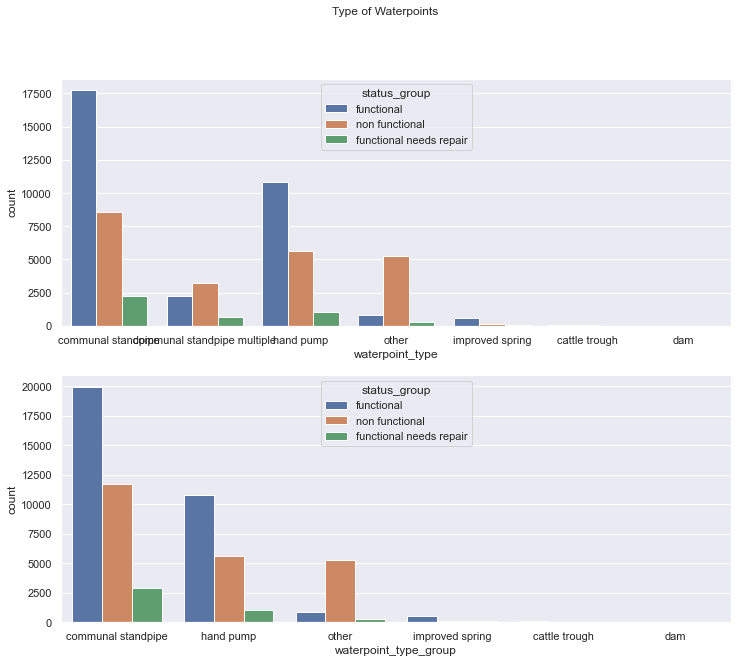

In [33]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10))
fig.suptitle('Type of Waterpoints')
sns.countplot(x='waterpoint_type', hue='status_group', data=df, ax=ax1)
sns.countplot(x='waterpoint_type_group', hue='status_group', data=df, ax=ax2)
plt.show();

Above: tertiary


Below: Binary

#### source, source_class, and source_type

source: Explains same information as source_type but with more variables. Keeping source_type.
source_class: Broadly explains same information as source and source_type. Keeping source_type.
Source_type: This was NOT dropped. Kept it as a balance between the other two features of similar information.

See below for visualization of the different groupings in terms of functional water pumps.

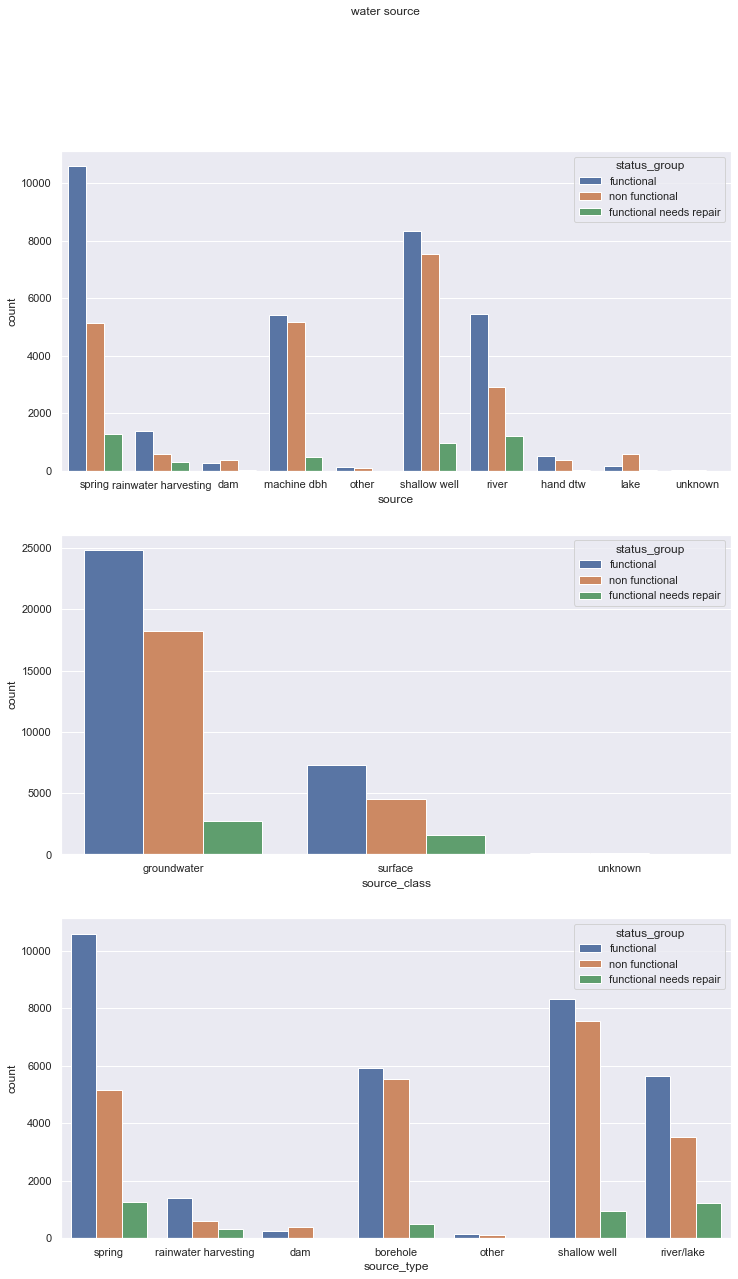

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,20))
fig.suptitle('water source')
sns.countplot(x='source', hue='status_group', data=df, ax=ax1)
sns.countplot(x='source_class', hue='status_group', data=df, ax=ax2)
sns.countplot(x='source_type', hue='status_group', data=df, ax=ax3)
plt.show();

Above: tertiary


Below: Binary

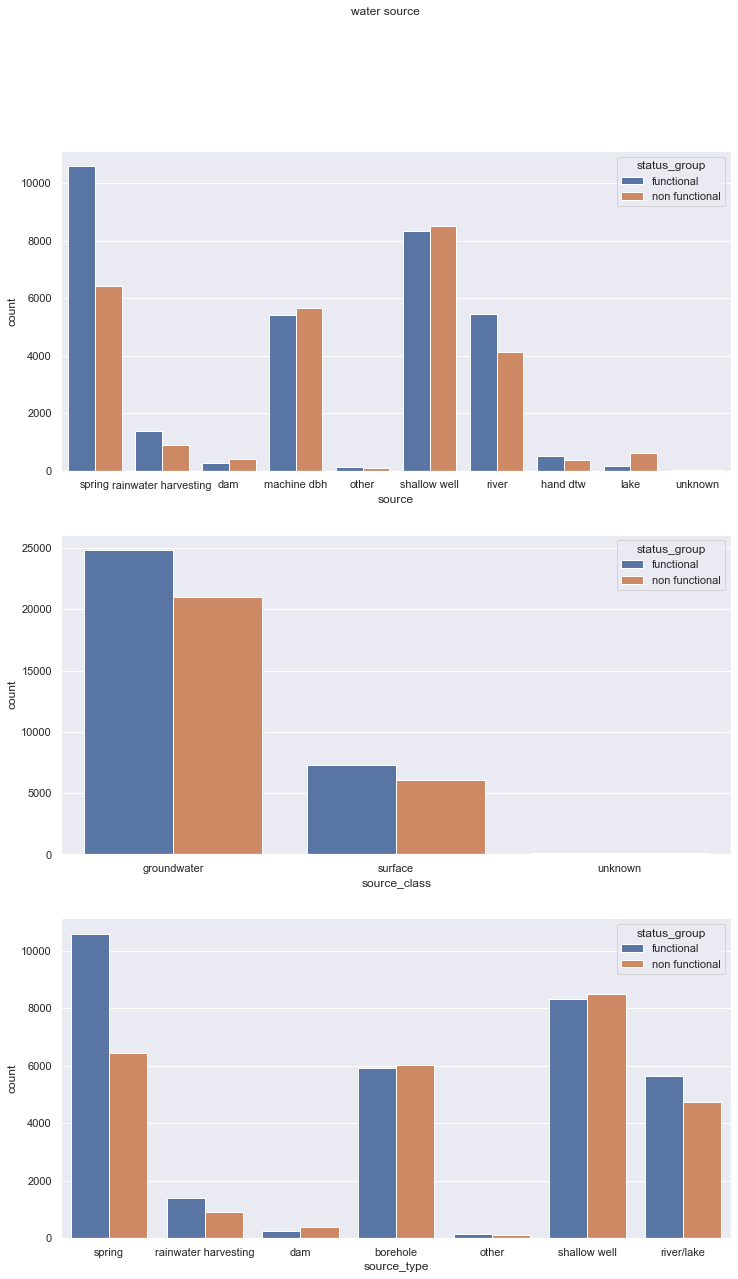

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,20))
fig.suptitle('water source')
sns.countplot(x='source', hue='status_group', data=df_binary, ax=ax1)
sns.countplot(x='source_class', hue='status_group', data=df_binary, ax=ax2)
sns.countplot(x='source_type', hue='status_group', data=df_binary, ax=ax3)
plt.show();

#### extraction_type, extraction_type_group, extraction_type_class

These three features explain a lot of the same information subgrouped in different ways. I decided to keep two and drop the third. The two that were dropped had columns with too little weight in the distrubtion for useful information. 

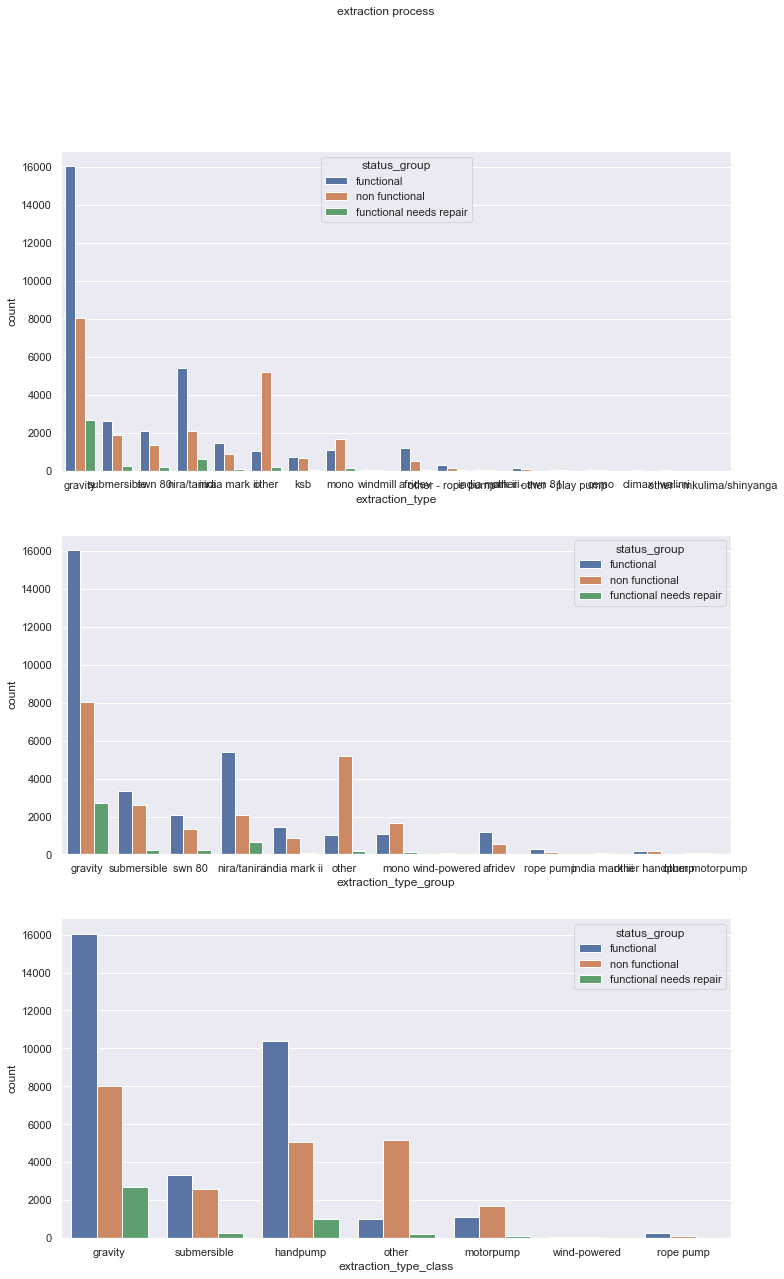

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,20))
fig.suptitle('extraction process')
sns.countplot(x='extraction_type', hue='status_group', data=df, ax=ax1)
sns.countplot(x='extraction_type_group', hue='status_group', data=df, ax=ax2)
sns.countplot(x='extraction_type_class', hue='status_group', data=df, ax=ax3)
plt.show();

Above: tertiary


Below: Binary

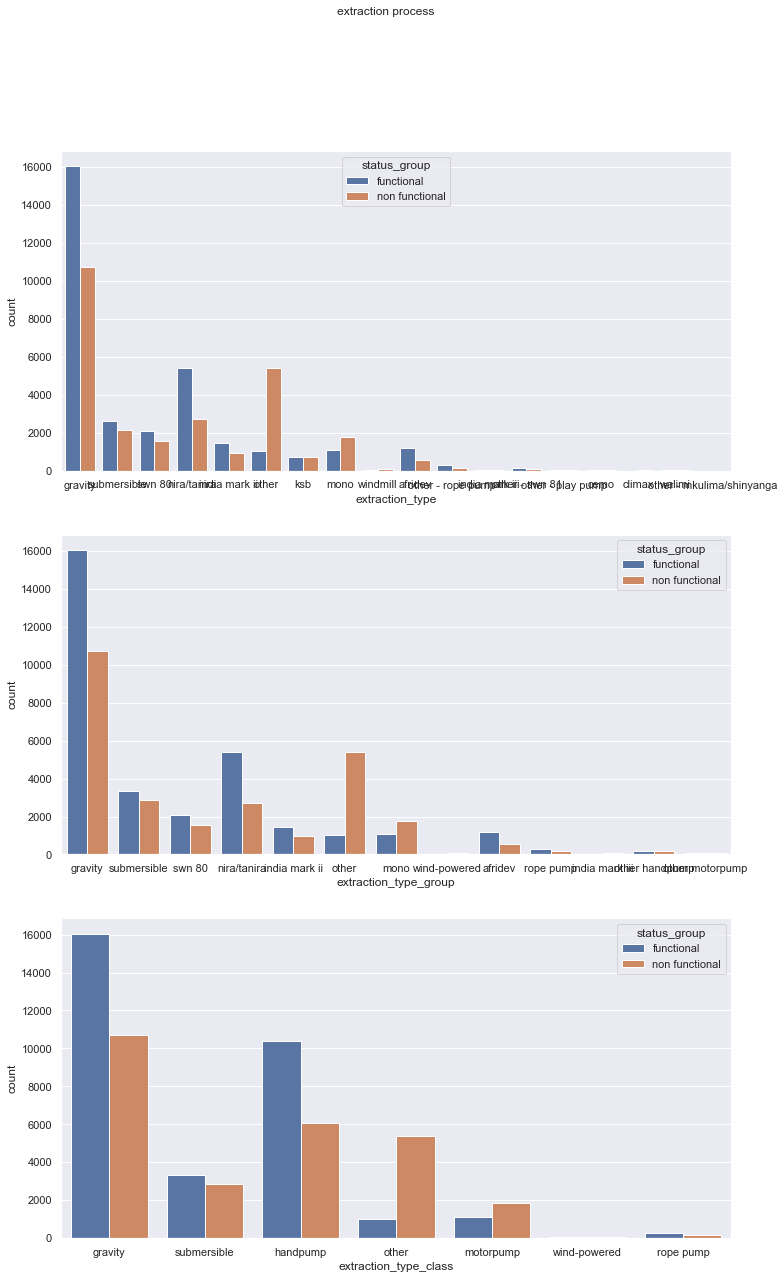

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,20))
fig.suptitle('extraction process')
sns.countplot(x='extraction_type', hue='status_group', data=df_binary, ax=ax1)
sns.countplot(x='extraction_type_group', hue='status_group', data=df_binary, ax=ax2)
sns.countplot(x='extraction_type_class', hue='status_group', data=df_binary, ax=ax3)
plt.show();

#### payment and payment_type

The information for both of these columns in nearly exactly identical. Drop 'payment_type' and keep 'payment'.

Most points that are not paid are not working. This may be due to a lack of maintenance resources. When a payment is added, the status changes. 

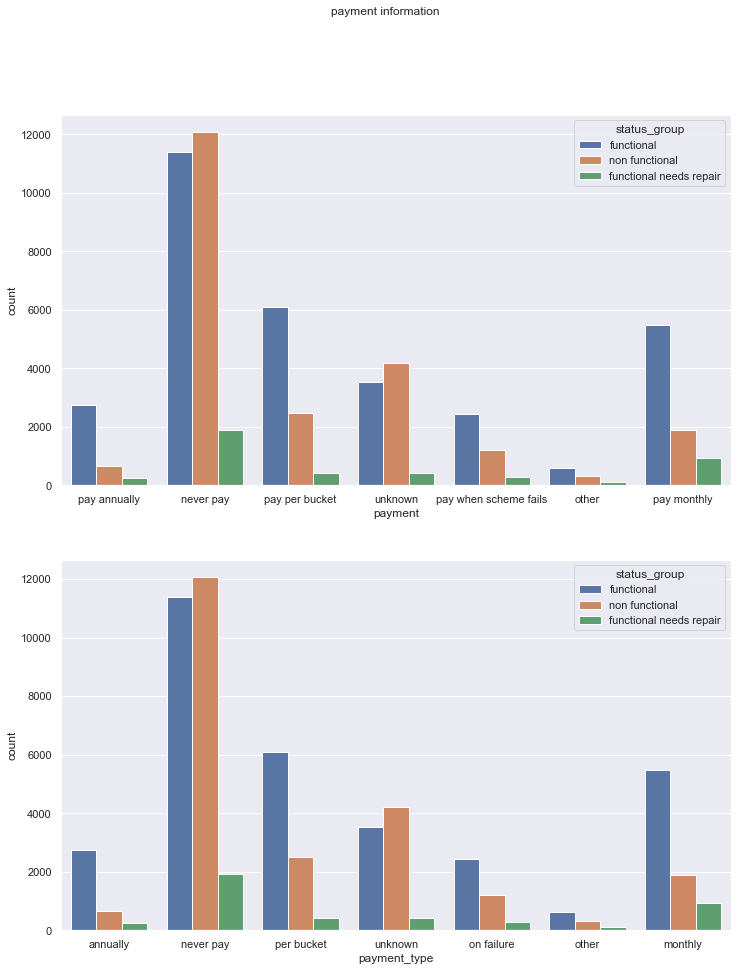

In [39]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,15))
fig.suptitle('payment information')
sns.countplot(x='payment', hue='status_group', data=df, ax=ax1)
sns.countplot(x='payment_type', hue='status_group', data=df, ax=ax2)
plt.show();

Above: tertiary


Below: Binary

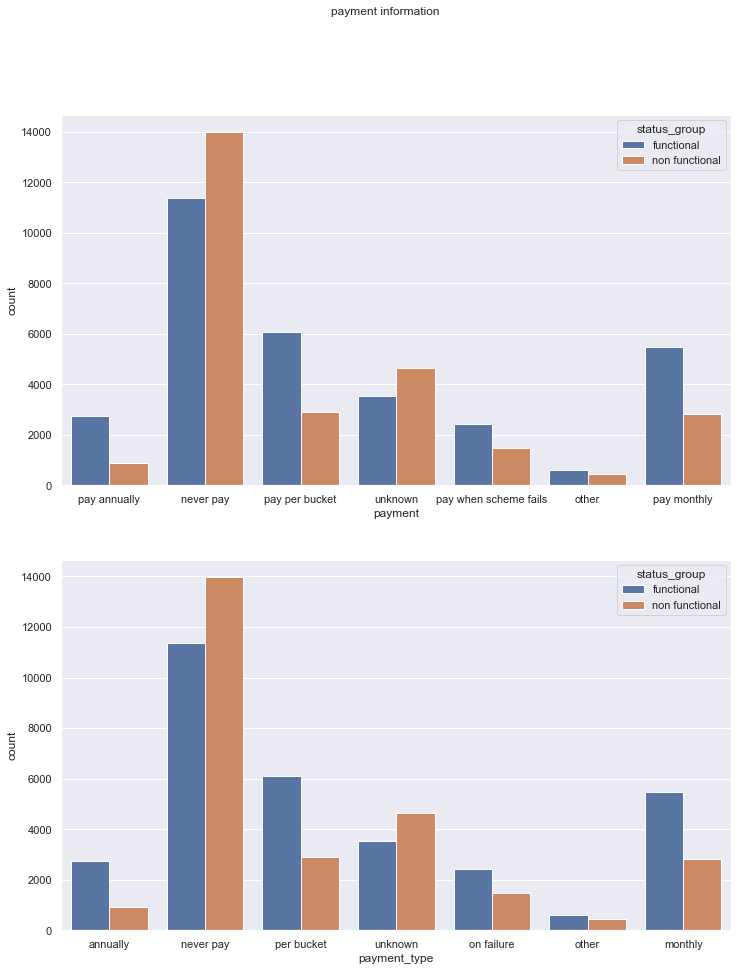

In [40]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,15))
fig.suptitle('payment information')
sns.countplot(x='payment', hue='status_group', data=df_binary, ax=ax1)
sns.countplot(x='payment_type', hue='status_group', data=df_binary, ax=ax2)
plt.show();

#### management and management_group

I decided to keep the 'management' column and group the less specific 'management_group' column. Alot of the columns in the management column should have enough information to help the model make better predictions. 

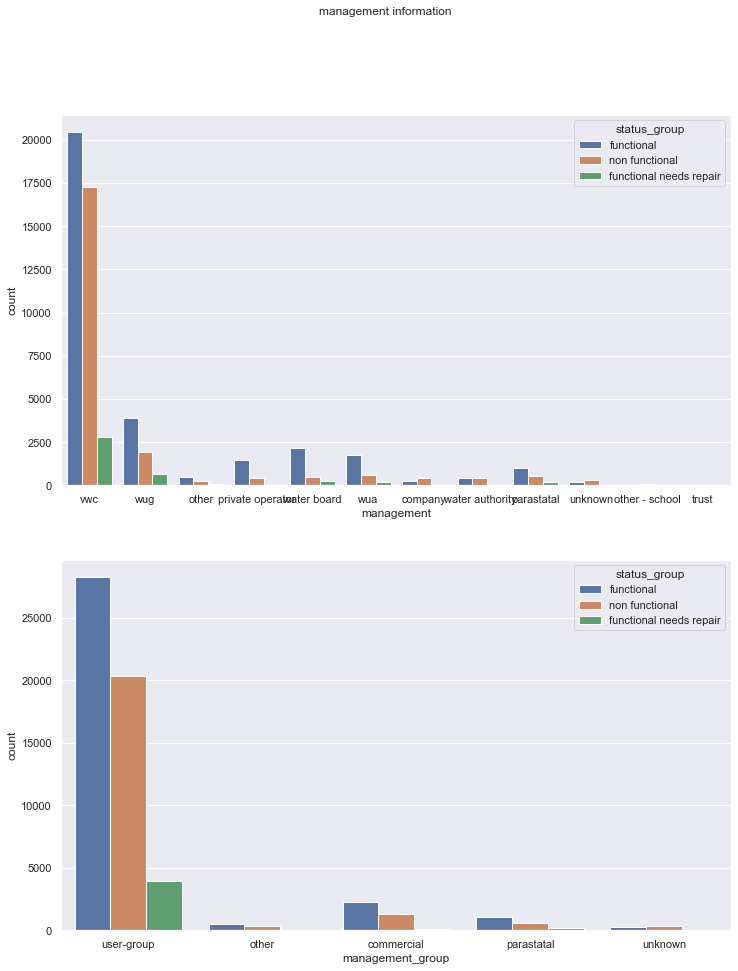

In [41]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,15))
fig.suptitle('management information')
sns.countplot(x='management', hue='status_group', data=df, ax=ax1)
sns.countplot(x='management_group', hue='status_group', data=df, ax=ax2)
plt.show();

Above: tertiary


Below: Binary

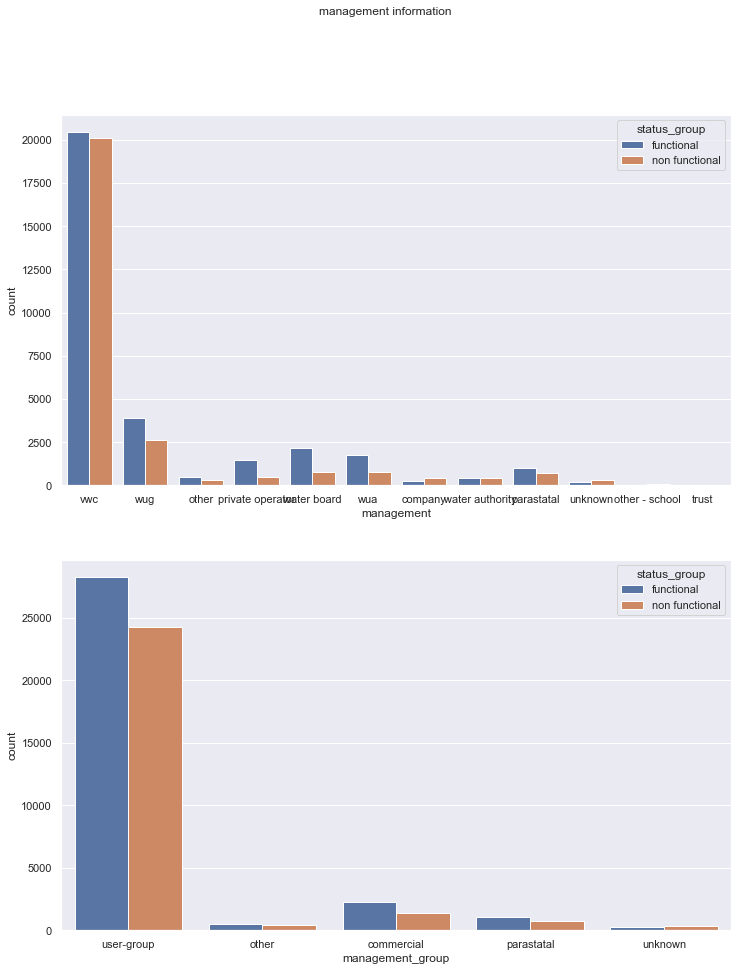

In [42]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,15))
fig.suptitle('management information')
sns.countplot(x='management', hue='status_group', data=df_binary, ax=ax1)
sns.countplot(x='management_group', hue='status_group', data=df_binary, ax=ax2)
plt.show();

#### scheme_name and scheme_management

scheme_name: drop. Missing almost half of values. Large cardinality (nearly 2700 categories).
scheme_manager: drop. Contains similar information to management column.

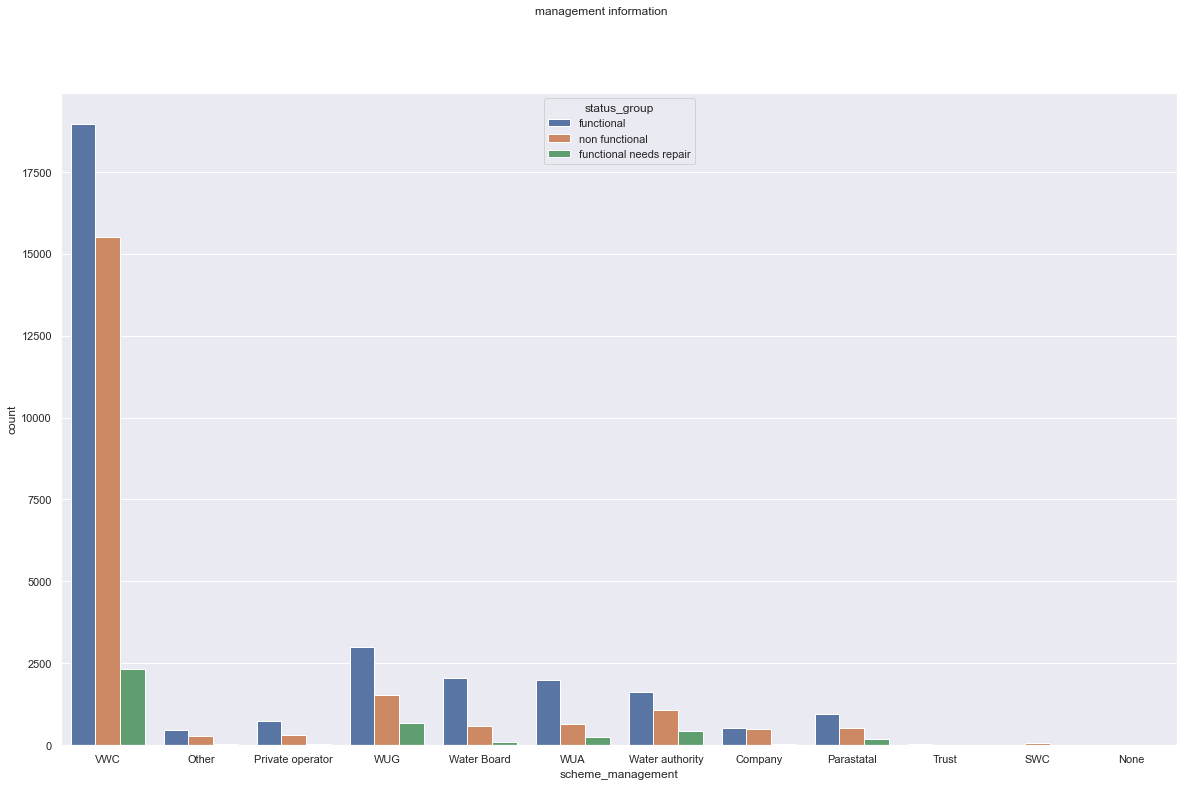

In [43]:
fig = plt.figure(figsize=(20,12))
fig.suptitle('management information')
sns.countplot(x='scheme_management', hue='status_group', data=df)
plt.show();

Above: tertiary


Below: Binary

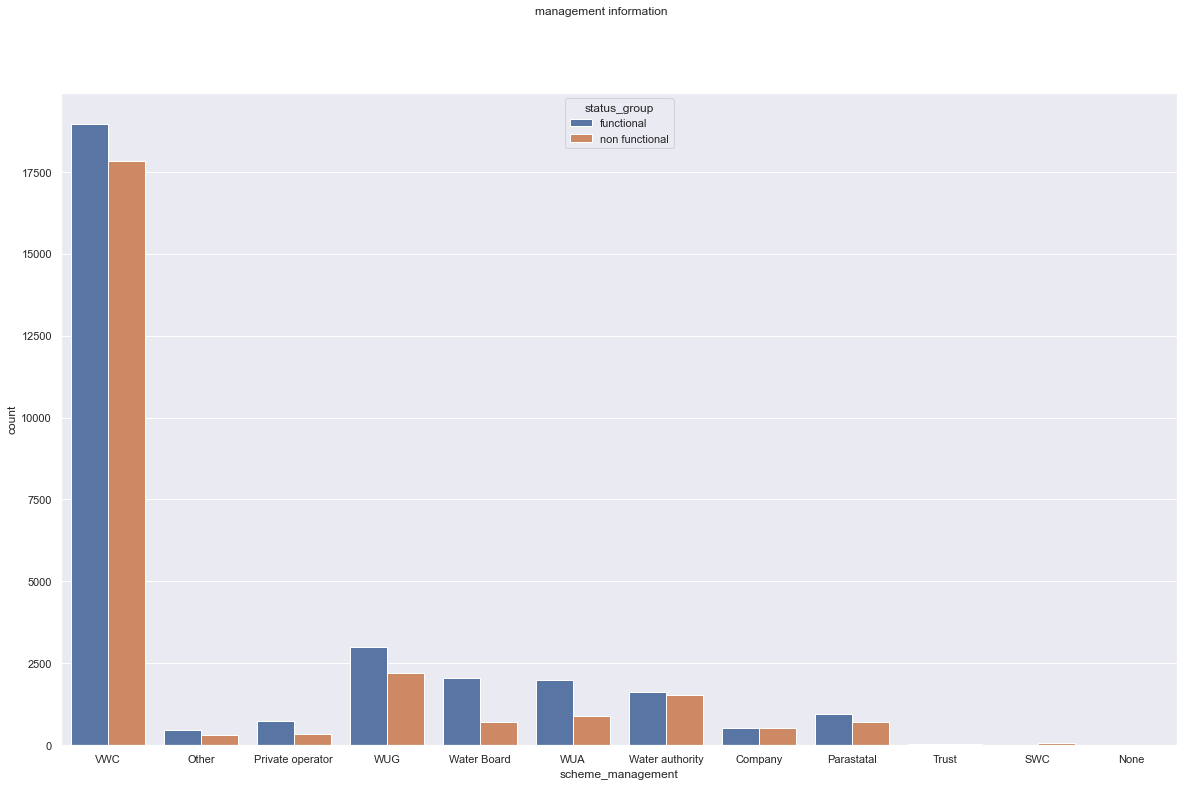

In [44]:
fig = plt.figure(figsize=(20,12))
fig.suptitle('management information')
sns.countplot(x='scheme_management', hue='status_group', data=df_binary)
plt.show();

In [45]:
to_drop = ['id', 'recorded_by', 'num_private',
          'waterpoint_type_group', 'source',
          'source_class', 'extraction_type',
          'extraction_type_group', 'payment_type',
          'management_group', 'scheme_name',
          'water_quality', 'quantity_group',
          'scheme_management', 'longitude',
          'latitude', 'date_recorded']
df2 = df.drop(to_drop, axis=1)
df2.head()

,amount_tsh,funder,gps_height,installer,wpt_name,basin,subvillage,region,region_code,district_code,...,extraction_type_class,management,payment,quality_group,quantity,source_type,waterpoint_type,status_group,near_river,ward_pop
0,6000.0,Roman,1390,Roman,none,Lake Nyasa,Mnyusi B,Iringa,11,5,...,gravity,vwc,pay annually,good,enough,spring,communal standpipe,functional,0.0,7346.0
1,0.0,Grumeti,1399,GRUMETI,Zahanati,Lake Victoria,Nyamara,Mara,20,2,...,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,1.0,12849.0
2,25.0,Lottery Club,686,World vision,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,...,gravity,vwc,pay per bucket,good,enough,dam,communal standpipe multiple,functional,1.0,7417.0
3,0.0,Unicef,263,UNICEF,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,...,submersible,vwc,never pay,good,dry,borehole,communal standpipe multiple,non functional,0.0,10826.0
4,0.0,Action In A,0,Artisan,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,...,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,1.0,12803.0


### Date_Recorded: Understanding Time Frame of Data Collection and Current Capacity Limits


As show in the bargraph below, almost all of the data was originally recorded between the years 2011 and 2013. The highest capacity for the Ministry of Water was in the year 2011 when 28,674 pumps were visited. It is important to consider the time-scale of the data when considering the cost/resource anaylsis of predictive modeling vs the current maintenance being conducted with no modeling.

In [ ]:
df3=df.copy()
df3['date_recorded'] = pd.to_datetime(df3['date_recorded'])

In [ ]:
df3['date_recorded'].dt.year.value_counts()

In [ ]:
df3.shape

In [ ]:
fig = plt.figure(figsize=(20,12))
fig.suptitle('year recorded')
sns.countplot(x=df3['date_recorded'].dt.year)
plt.show();

*Speculate on the amount of labor required to physically check all of these pumps in a 2 to 3 year period. This will give a good understanding of the current cost and capacity without using any predictive maintenance.*

### Dealing with Null Values and '0' placeholder values

This section covers the handeling of null values in the data in preperation for modeling.

## consider making function for transforming (pipeline)

#### funder and Installer null values

In [ ]:
print(df2['funder'].isna().sum())
print(df2['installer'].isna().sum())
df2[df2['funder'].isna()].index.isin(df2[df2['installer'].isna()].index).sum()

In [ ]:
df2['installer'].value_counts()[:20]

In [ ]:
df2['funder'].value_counts()[:20]

In [ ]:
installer_index_0 = df2['installer'] =='0'
funder_index_0 = df2['funder'] =='0'
#replace zero placeholders with 'unknown'
df2.loc[funder_index_0, 'funder'] = 'unknown'
df2.loc[funder_index_0, 'installer'] = 'unknown'
#replace null values as 'unkown'
df2['installer'].fillna(value='unknown', inplace=True)
df2['funder'].fillna(value='unknown', inplace=True)
#sanity check
display(df2['funder'].value_counts()[:20])
display(df2['installer'].value_counts()[:20])
df2.isna().sum()

#### public meeting null values

In [ ]:
display(df2['public_meeting'].value_counts(normalize=True))
df2['public_meeting'].value_counts(dropna=False,normalize=True)

In [ ]:
#create copy of dataframe
df_pub_no_na = df2.copy()
#initialize boolean series for null values in pub meeting
filt = df_pub_no_na['public_meeting'].isna()
#initialize series in order to keep ratio of boolean the same
#after filling null values
probs = df2['public_meeting'].value_counts(normalize=True)
#fill null values with random selection of 
#True or False but keep same probability as before filling NaNs
df_pub_no_na.loc[filt, 'public_meeting'] = np.random.choice([True, False], 
                   size=int(filt.sum()),
                   p = [probs[True], probs[False]])

#check to see NaNs are filled without changing probabilities
df_pub_no_na['public_meeting'].value_counts(dropna=False, normalize = True)

#### permit null values

In [ ]:
df3 = df_pub_no_na.copy()
df3.isna().sum()

In [ ]:
df3['permit'].value_counts(dropna=False, normalize=True)

In [ ]:
#initialize boolean series for null values in permit
filt2 = df3['permit'].isna()
#initialize series in order to keep ratio of boolean the same
#after filling null values
probs2 = df3['permit'].value_counts(normalize=True)
#fill null values with random selection of 
#True or False but keep same probability as before filling NaNs
df3.loc[filt2, 'permit'] = np.random.choice([True, False], 
                   size=int(filt2.sum()),
                   p = [probs2[True], probs2[False]])

df3['permit'].value_counts(dropna=False, normalize=True)

#### subvillage null values

In [ ]:
#grab indexes of null values to fill for scheme_management column
subvillage_index_null = df3[df3['subvillage'].isna()].index
#fill null values with 'unknown'
df3.loc[subvillage_index_null, 'subvillage'] = 'unknown'

df3.isna().sum()

## High Cardinality Categorical Data

There are numerous ways to deal with categorical data with high cardinality. It is important when creating machine learning models to pay attetion to the dimensionality of the data. It can get out of hand really quickly if you do nothing to limit your cardinality. One of the simplest and easiest ways to follow is to take the categories with the highest frequencies (and therefore makeup the bulk of the distrubtion for that particular category) are left as is until a certain threshold of the data has been accounted for. After the threshold is met, all other categories for that column (which can sometimes be thousands of categories) will get lumped into a new category labled as 'other.'

This simple trick can easily reduce dimensionality of categorical data. While it is not the most sophisticated method, it should be good enough for the models I want to create for my project. 

Below is a function I created in order to easily reduce cardinality in my categorical data by using the method described above. My default threshold value is 75%, meaning after 75% of the data is accounted for, all other categories of lower frequencies will be lumped together into the 'other' category. 

This code was inspired by author Raj Sangani in his blog: [Dealing with features that have high cardinality](https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b). Thank you for the well commented and easy to follow along code!

Here is the documentation for the import necessary for the function below from python collections library: Counter.
[collections.Counter](https://docs.python.org/3/library/collections.html#collections.Counter). Here we use the method 'most_common()' of collections.Counter. 

From the documentation:

**most_common([n]):**
Return a list of the n most common elements and their counts from the most common to the least. If n is omitted or None, most_common() returns all elements in the counter. Elements with equal counts are ordered in the order first encountered.


This function is ok for initial data exploration. However, it will need to be tweaked later in order to be implemeted approriately into a data processing pipeline. Instead of returning an updated column, future implementation will return a dictionary that will act as a value mapper in order to reduce cardinality of training and testing sets. The value mapper dictionary will be created by running the function on the entire dataset before carrying out the actual data processing/cleaning. 

In [ ]:
def cardinality_threshold(column,threshold=0.75,return_categories_list=True):
      #calculate the threshold value using
      #the frequency of instances in column
      threshold_value=int(threshold*len(column))
      #initialize a new list for lower cardinality column
      categories_list=[]
      #initialize a variable to calculate sum of frequencies
      s=0
      #Create a dictionary (unique_category: frequency)
      counts=Counter(column)

      #Iterate through category names and corresponding frequencies after sorting the categories
      #by descending order of frequency
      for i,j in counts.most_common():
        #Add the frequency to the total sum
        s += dict(counts)[i]
        #append the category name to the categories list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s >= threshold_value:
            break
      #append the new 'Other' category to list
      categories_list.append('Other')

      #Take all instances not in categories below threshold  
      #that were kept and lump them into the
      #new 'Other' category.
      new_column = column.apply(lambda x: x if x in categories_list else 'Other')

      #Return the transformed column and
      #unique categories if return_categories = True
      if(return_categories_list):
        return new_column,categories_list
      #Return only the transformed column if return_categories=False
      else:
        return new_column

#### funder categorical column

This column has a lot of categories that seem to be abbreviations or mispellings of the same funders. Ideally, I would correct all of these inconsistencies in the data in order to have my model perform the best that it can perform. However, for the scope of this project, I am going to put this tedious task off for now. 

In [ ]:
df3['funder'].sort_values().unique()[:200]

In [ ]:
transformed_funder = cardinality_threshold(df3['funder'],
                                           threshold=0.65,
                                           return_categories_list=False)

transformed_funder.value_counts()

In [ ]:
df_transformed = df3.copy()
df_transformed['funder'] = transformed_funder

fig = plt.figure(figsize=(12,15))
fig.suptitle('funder information')
sns.countplot(y= 'funder', hue='status_group', data=df_transformed)
plt.show();

#### Transforming installer column

In [ ]:
transformed_installer = cardinality_threshold(df3['installer'],
                                           threshold=0.65,
                                           return_categories_list=False)

transformed_installer.value_counts()

In [ ]:
df_transformed['installer'] = transformed_installer

fig = plt.figure(figsize=(12,15))
fig.suptitle('installer information')
sns.countplot(y= 'installer', hue='status_group', data=df_transformed)
plt.show();

#### wpt_name transformation

In [ ]:
transformed_wpt_name = cardinality_threshold(df3['wpt_name'],
                                           threshold=0.15,
                                           return_categories_list=False)

transformed_wpt_name.value_counts()

In [ ]:
df_transformed['wpt_name'] = transformed_wpt_name

fig = plt.figure(figsize=(12,15))
fig.suptitle('wpt_name information')
sns.countplot(y= 'wpt_name', hue='status_group', data=df_transformed)
plt.show();

#### subvillage transformation

In [ ]:
transformed_subvillage = cardinality_threshold(df3['subvillage'],
                                           threshold=0.07,
                                           return_categories_list=False)

transformed_subvillage.value_counts()

In [ ]:
df_transformed['subvillage'] = transformed_subvillage

fig = plt.figure(figsize=(12,15))
fig.suptitle('subvillage information')
sns.countplot(y= 'subvillage', hue='status_group', data=df_transformed)
plt.show();

#### lga transformation

In [ ]:
transformed_lga = cardinality_threshold(df3['lga'],
                                           threshold=0.6,
                                           return_categories_list=False)

transformed_lga.value_counts()

In [ ]:
df_transformed['lga'] = transformed_lga

fig = plt.figure(figsize=(12,15))
fig.suptitle('lga information')
sns.countplot(y= 'lga', hue='status_group', data=df_transformed)
plt.show();

#### ward transformation

In [ ]:
transformed_ward = cardinality_threshold(df3['ward'],
                                           threshold=0.05,
                                           return_categories_list=False)

transformed_ward.value_counts()

In [ ]:
df_transformed['ward'] = transformed_ward

fig = plt.figure(figsize=(12,15))
fig.suptitle('ward information')
sns.countplot(y= 'ward', hue='status_group', data=df_transformed)
plt.show();

In [ ]:
df3.columns

### zero skewed data

#### population

The column describing population is heavily skewed towards a value of zero, and it would seem very unlikely for so many wells to have a population of zero. Nearly 50% of the data is skewed towards a value of either zero or one. It is hard to trust the validaty of this column. I decided to drop this column and bring in population information by ward collected by government census in 2012. This data has its own issues but I believe it to be a more complete dataset and give a better idea about the number of people who could benefit from the presence of a functional well in their area. Ward is a pretty high level division of geological boundaries for Tanzania. May have to revisit this population data at a later date. See beginning of notebook to see how population data was added by ward. 

#### construction_year

This column is heavily skewed towards a value of zero. Zero seems to be a placeholder for unkown construction year.
This column will be turned into a categorical column with binned decades and a column to replace zeroes with 'unknown'.

In [ ]:
#with zeroes
df['construction_year'].describe()

In [ ]:
#without zeroes (placeholder values)
construction_zero_index = df3[df3['construction_year'] == 0].index
df_construction = df3.drop(construction_zero_index)
df_construction['construction_year'].describe()

In [ ]:
sns.countplot(x='construction_year', hue='status_group', data = df_construction)

In [ ]:
#bin construction year into decades and 'unknown' for zeroes


def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
df_transformed['construction_year'] = df_transformed.apply(lambda row: construction_wrangler(row), axis=1)

In [ ]:
df_transformed['construction_year'].value_counts()

In [ ]:
fig = plt.figure(figsize=(15,12))
fig.suptitle('construction_year binned')
sns.countplot(x = 'construction_year', hue='status_group', data=df_transformed)
plt.show();

#### amount_tsh

In [ ]:
df_transformed['amount_tsh'].sort_values(ascending=False)[:50]

### Amount_tsh

This column describes the total static head of each pump. It could be very useful in determining the amount of water available at each well. However, the data is extremely skewed towards the value of zero. There also seems to be extreme outliers in the other direction as well, with a value of 350000. Also, there are no dimensions in the data to know what the scale is. It could be feet or meters or something else. 

Dealing with the large skew (over 70%) towards the value of zero is out of the scope for my project. I will drop this column for now and move on. 

In [ ]:
df_transformed.drop(columns=['amount_tsh'], axis=1, inplace=True)

### GPS height

This column also has a skew towards zero. Nearly 35% of the values are zero. I am going to drop this column for now.

In [ ]:
df_transformed.drop(columns=['gps_height'], axis=1, inplace=True)

In [ ]:
df_transformed.info()

In [ ]:
df_transformed.columns

In [ ]:
df_transformed.drop(columns=['region_code', 'district_code'], axis=1, inplace=True)

In [ ]:
df_transformed.columns

Below is some additional geographical/census/population data that could prove useful in improving modeling in future work. Due to time constraints, the data was not thoroughly explored. 

I kept it below for now as an example of ways to bring in more information from government resources in order to explore new ways to improve predictive capabilities of any future modeling.

In [ ]:
# df1 = pd.read_csv('data/region_points.csv')

# df2 = pd.read_csv('data/ObservationData_eqpqcq.csv')
# region_list = list(train_features['region'].unique())
# df_2 = df2[df2['region'].isin(region_list)]

# df3 = pd.read_csv('data/ObservationData_mzztfvd.csv')

In [ ]:
# len(df3[df3['location'].isin(region_list)]['location'].unique())
# df2[df2['indicator'] == 'Revenue Collection (Tshs)'].groupby('region').mean()['Value']
# df_2.groupby(['region', 'indicator']).mean()
# df3[df3['variable'] == 'Mean Maximum Temperature (°C)'].groupby('location').mean().index
# dfT = pd.read_csv('data/ObservationData_eqpqcq.csv')
# dfT2 = pd.read_csv('data/ObservationData_mzztfvd.csv')

# dfT2.head()

### End of Exploratory Notebook

This is the end of data exploration and of this jupyter notebook. Please feel free to reach me at the following email for any questions or comments. Please continue on to my modeling notebook which contains information about what classification metrics are most important to consider given my buisness problem, all data preprocessing steps, and all modeling steps. Thank you!

Author Name: Dylan Dey

Email: ddey2985@gmail.com

Github: